# Current development
**Option 1 - Soft physics (not solving ODE)**: Saw a paper that decouple completely the physics part: redesign the PUNN network to predict position directly, to compare with the acceleration that comes from the physical model (therefore defining the loss function). In practice the phy position is from the acc integration (with euler or runge-kutta) This avoids autodiff entirely. Doesnt even have IC/BC loss. (Geng et al., Mo et al.)

~~**Option 2 - Hard physics (solve ODE) but tweak current approach**: Architecturally decouple the time derivative computation from 𝑢(𝑡) by, for instance, constructing a subnetwork that takes only 𝑡 as input for computing derivatives, while 𝑢 is applied externally in the physics loss computation. Two networks: PUNN and PINN but where the PINN is just to leverage tensorflow computational graph and has only t as input.~~ > I think im mistaking forward vs inverse problem here

# Imports

In [101]:
from scipy.interpolate import interp1d
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras import Loss
import seaborn as sns

# Train on single vehicle dynamics

## Constant coefficient car

In [76]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate

        self.X = np.array(x0, dtype=float) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""

        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)


        # Rk4
        k1 = self._dynamics(self.X, u)
        a = k1[1] #gets v_dot = actual acceleration
        self.history["a"].append(a)

        k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        k4 = self._dynamics(self.X + dt*k3, u)

        self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)

        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        return np.array([v, a])

## Generate synthetic data

In [77]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
v0 = 20/3.6
x0 = (0, v0) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)

#DEFINE U
t_samp = np.array([0, 40, 100, 200, 250, t_end]) #time check points
u_samp_train = np.array([0, 0.2, 1, 0.4, 0.3, 0.1]) * m # traction force (input from engine)
u = interp1d(t_samp, u_samp_train, kind='linear') #quadratic interpolation -> no drivetrain limitation for now

#generate data:
for t_curr in t:
    car.update(u(t_curr), dt)

# for validation later (different trajectory):

### Simulate measurements (add noise)

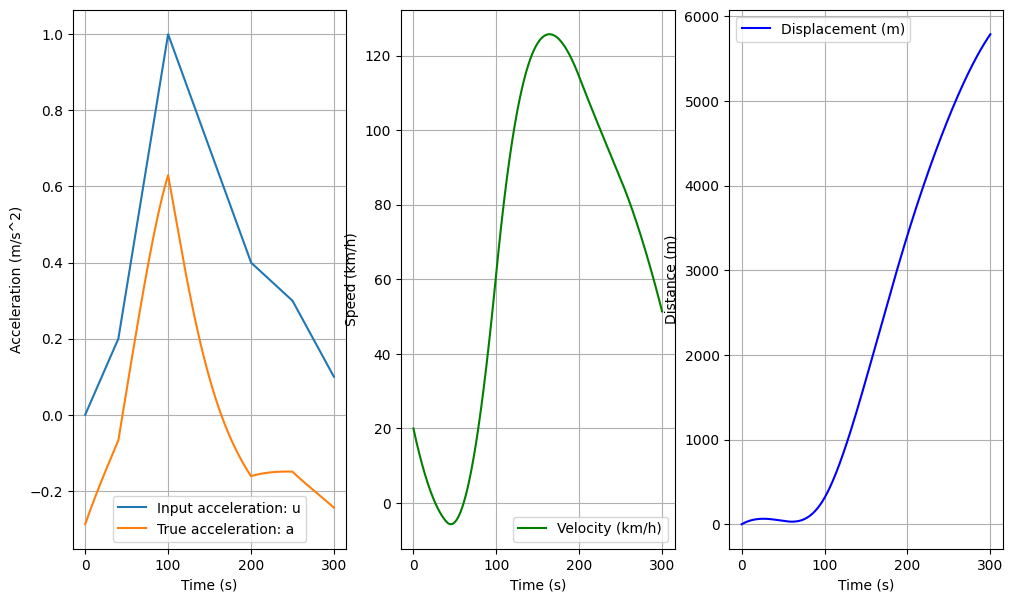

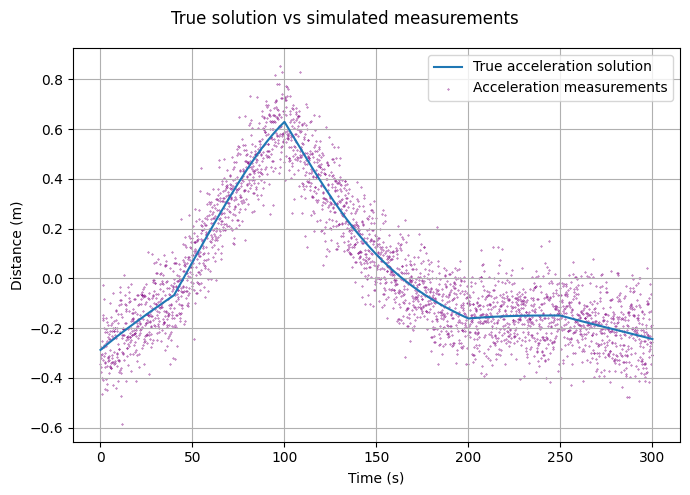

In [149]:
variance = 0.1

Y_true = np.array(car.history["a"]).reshape(-1,1)
Y_noise = Y_true + np.random.normal(0, variance, size=Y_true.shape)
v_true = np.array(car.history["v"]) # in m/s
x_true = np.array(car.history["x"])

fig = plt.figure(figsize=(12,7))
ax=fig.subplots(1,3)

ax[0].plot(t, np.array(car.history["u"])/car.m, label = "Input acceleration: u")
ax[0].plot(t, car.history["a"], label="True acceleration: a")
ax[0].set_ylabel("Acceleration (m/s^2)")

ax[1].plot(t, np.array(car.history["v"])*3.6, label="Velocity (km/h)", color="green")
ax[1].set_ylabel("Speed (km/h)")

ax[2].plot(t, np.array(car.history["x"]), label="Displacement (m)", color="blue")
ax[2].set_ylabel("Distance (m)")

for i in range(len(ax)):
    ax[i].set_xlabel("Time (s)")
    ax[i].legend()
    ax[i].grid()

plt.figure(figsize=(7,5))
plt.suptitle("True solution vs simulated measurements")
plt.plot(t, Y_true, label="True acceleration solution")
plt.scatter(t, Y_noise, label="Acceleration measurements", s=0.1, color="purple")
plt.ylabel("Distance (m)")
plt.grid()
plt.legend()
plt.xlabel("Time (s)")
plt.tight_layout()

## Forward Problem

In [153]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray, meas_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''
    
    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12, 8))
    plt.suptitle(suptitle)

    # Plot for acceleration:
    plt.subplot(1, 3, 1)
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    plt.scatter(t, meas_data, label="Measured acceleration points", s=7, color="red")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1, 3, 2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()

    
    plt.subplot(1, 3, 3)
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    stopped_epoch = np.argmin(val_loss) + 1  # Get the epoch with the minimum validation loss

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    # Add a marker for the early stopping epoch
    plt.axvline(x=stopped_epoch, color='r', linestyle='--', label='Early Stopping')
    plt.text(stopped_epoch, val_loss[stopped_epoch - 1], f'({stopped_epoch}, {val_loss[stopped_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()


# Prepping data

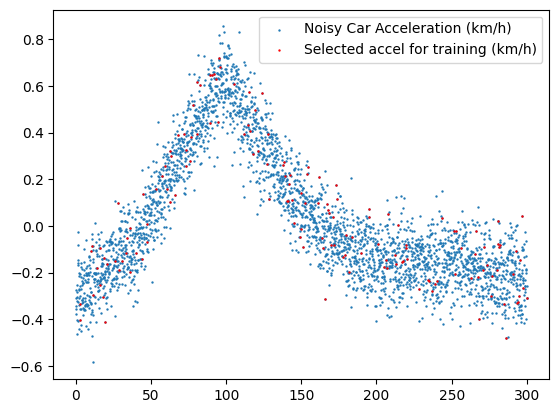

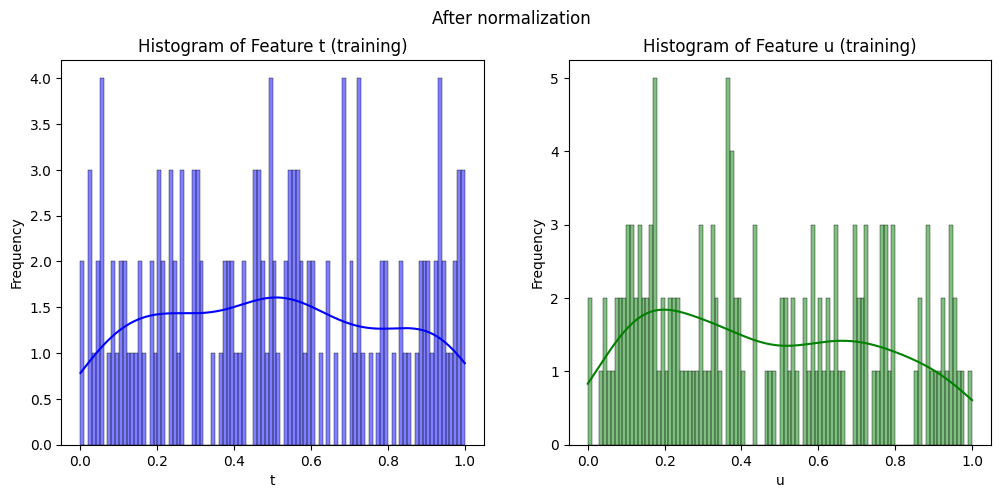

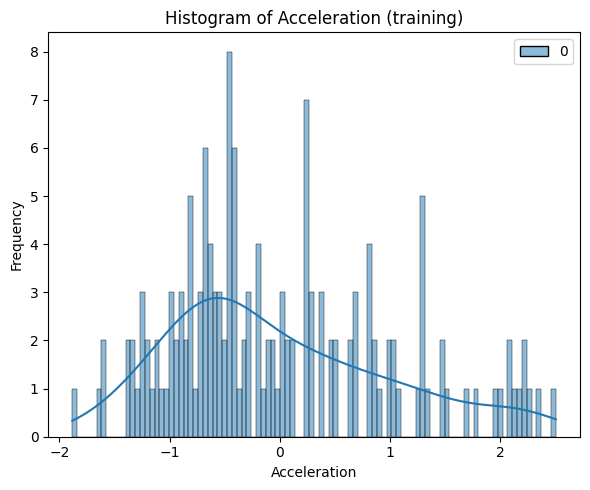

In [151]:
# prepping the data
train_ratio = .05
X = np.stack([t, u(t)], axis=-1) #t and u as features

Y_train, Y_test, X_train, X_test = train_test_split(Y_noise, X, train_size=train_ratio, random_state=31)
#print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_noise, Y_train)
Y_mask = Y_noise.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_noise, label="Noisy Car Acceleration (km/h)", s=.5)
plt.scatter(t, Y_mask, label="Selected accel for training (km/h)", s=.5, color="red")
plt.legend()
plt.show()

#Prediction Normalization
# if we dont do this, position contributes more to the loss, due to the sheer inbalance of scale
scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_test_norm = scaler_Y.transform(Y_test)
Y_true_norm = scaler_Y.transform(Y_true)
y_0_norm = Y_true_norm[0, :]

# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_test_norm = scaler_X.transform(X_test)
X_norm = scaler_X.transform(X)
x_0_norm = X_norm[0, :]

# Plot histograms for features and outputs using seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("After normalization")

# Plot histograms for features
sns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Histogram of Feature t (training)')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Frequency')

sns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=ax[1], color='green')
ax[1].set_title('Histogram of Feature u (training)')
ax[1].set_xlabel('u')
ax[1].set_ylabel('Frequency')

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train_norm, bins=100, kde=True, color='orange')
plt.title('Histogram of Acceleration (training)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# PUNN-only

In [ ]:
#globals
#------
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
metrics = []
opt = Adam(learning_rate=1e-4, weight_decay=1e-3)
loss = "mse"
patience = 50
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
def lr_schedule(epoch, lr):
    if (epoch+1) % 50 == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/punn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(2, ))) #input: t,u
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(1, activation="linear")) #output layer -> a^
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#with output scaling:
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm, Y_true_norm),
                                  batch_size=16, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history)

In [ ]:
punn_model.save("models/punn_model_forward.h5")

## PUNN predictions
offline integration for testing, in reality it would be real-time

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Normalized MSE/RMSE for acceleration: 8.49683e-03, 9.21783e-02
Physical MSE/RMSE for acceleration: 6.33072e-04, 2.51609e-02
Real MSE/RMSE for velocity: 6.68959e+00, 2.58642e+00
Real MSE/RMSE for position: 7.31463e+04, 2.70456e+02


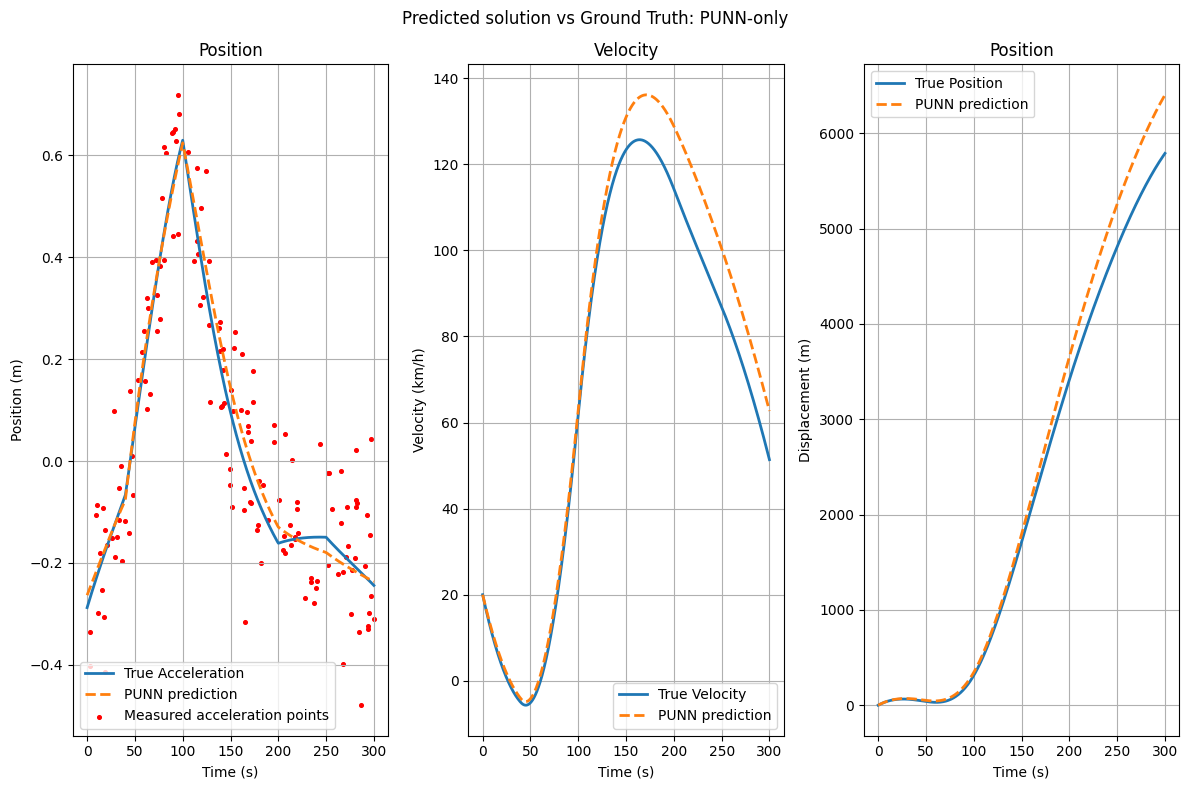

In [154]:
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
traj_true = np.hstack((Y_true, v_true.reshape(-1,1), x_true.reshape(-1,1))) #shape(t, 3) -> acceleration, velocity (km/h), position

punn_v_phy = np.zeros_like(t) 
punn_x_phy = np.zeros_like(t) 
punn_x_phy[0], punn_v_phy[0] = x0 #defined in m/s in the beginning

#vectorized preodiction offline
punn_a_norm = punn_model.predict(X_norm) 
punn_a_phy = scaler_Y.inverse_transform(punn_a_norm).flatten()

for i in range(len(t)-1):
    punn_v_phy[i+1] = punn_v_phy[i] + punn_a_phy[i] * dt #m/s
    punn_x_phy[i+1] = punn_x_phy[i] + punn_v_phy[i] * dt #in m

mse_a_norm = mean_squared_error(Y_true_norm, punn_a_norm) 
mse_a_phy = mean_squared_error(Y_true, punn_a_phy)
mse_x, mse_v = mean_squared_error(x_true, punn_x_phy), mean_squared_error(v_true, punn_v_phy)

punn_a_phy = punn_a_phy.reshape(-1, 1)
punn_v_phy = punn_v_phy.reshape(-1,1)
punn_x_phy = punn_x_phy.reshape(-1,1)
punn_pred_data = np.hstack((punn_a_phy, punn_v_phy, punn_x_phy))

print(f"Normalized MSE/RMSE for acceleration: {mse_a_norm:.5e}, {np.sqrt(mse_a_norm):.5e}")
print(f"Physical MSE/RMSE for acceleration: {mse_a_phy:.5e}, {np.sqrt(mse_a_phy):.5e}")
print(f"Real MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
print(f"Real MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

comparison_plot(t=t, true_data=traj_true, meas_data=Y_mask,
    pred_data=[(punn_pred_data, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only"
)

# PINN

In [ ]:
collocation_size = len(t) #trying to increase collocation poins for better physics convergence
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = u(t_c)
X_c = np.stack([t_c, u_c], axis=-1)
X_c_norm = scaler_X.transform(X_c)

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y_0_norm: np.ndarray, x_0_norm: np.ndarray,
                 scaler_X: MinMaxScaler, scaler_Y, loss_weights: tuple[float, float, float]):
        super().__init__()
        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #initial conditions
        self.y_0_norm = y_0_norm
        self.x_0_norm = x_0_norm
        self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X

        # Convert to tensor and separate components
        X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)
        self.t_c_norm = X_c_norm[:, 0]  # normalized time collocation points
        # Stop gradient for u component to prevent physics contamination
        self.u_c_norm_fixed = tf.stop_gradient(X_c_norm[:, 1])
        self.X_c_norm_fixed = tf.stack([self.t_c_norm, self.u_c_norm_fixed], axis=-1)

        # Precompute denormalized u values for physics equations
        X_c_denorm = scaler_X.inverse_transform(X_c_norm)
        self.u_phy = X_c_denorm[:, 1]  # physical u values for collocation points

    def data_loss(self, y_true, y_pred):
        """Calculate MSE between predictions and measurements"""
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        """Calculate PDE residual loss using automatic differentiation"""
        g = 9.81
        car = self.car

        with tf.GradientTape(persistent=True) as tape:
            # Watch the entire input tensor but u has stopped gradients
            tape.watch(self.X_c_norm_fixed)
            y_norm = self.model(self.X_c_norm_fixed)
            y_norm_x = y_norm[:, 0]  # normalized position prediction
            y_norm_v = y_norm[:, 1]  # normalized velocity prediction

        # Compute gradients for both outputs w.r.t all inputs
        grad_x_norm = tape.gradient(y_norm_x, self.X_c_norm_fixed)
        grad_v_norm = tape.gradient(y_norm_v, self.X_c_norm_fixed)
        del tape  # Explicitly delete persistent tape

        # Extract time derivatives (u gradients are zero due to stop_gradient)
        dx_dt_norm = grad_x_norm[:, 0]  # position derivative w.r.t normalized time
        dv_dt_norm = grad_v_norm[:, 0]  # velocity derivative w.r.t normalized time

        # Denormalize outputs using StandardScaler parameters
        y_phy = y_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_
        v_phy = y_phy[:, 1]  # physical velocity

        # Get scaling factors from MinMaxScaler
        t_scale = self.scaler_X.scale_[0]  # time normalization scale factor

        # Convert normalized derivatives to physical units
        dx_dt = dx_dt_norm * t_scale * self.scaler_Y.scale_[0]
        dv_dt = dv_dt_norm * t_scale * self.scaler_Y.scale_[1]

        # Calculate resistance forces using vehicle parameters
        Fr = (car.c0 + car.c1 * v_phy) * (car.m * g * np.cos(car.road_grade))
        Fa = (car.p * car.Cd * car.Af * v_phy**2) / 2
        Fg = car.m * g * np.sin(car.road_grade)

        # Compute physics residuals
        res_x = dx_dt - v_phy  # dx/dt should equal velocity
        res_v = car.m * dv_dt - (self.u_phy - Fr - Fa - Fg)  # Newton's law

        # Combine and average residuals
        res = tf.stack([res_x, res_v], axis=1)
        return tf.reduce_mean(tf.square(res))

    def boundary_loss(self):
        """Enforce initial condition matching"""
        y0_pred = self.model(self.x_0_norm[tf.newaxis, :])
        sqr_diff = tf.square(y0_pred - self.y_0_norm)
        return tf.reduce_mean(sqr_diff)

    def call(self, y_true, y_pred):
        """Combine loss components with weighting factors"""
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return (
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss +
            self.alpha_b * bound_loss
        )

## Combined Loss

In [ ]:
collocation_size = X_train_norm.shape[0] #same length as training time instants (for now)
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = u(t_c)
X_c = np.stack([t_c, u_c], axis=-1)
X_c_norm = scaler_X.transform(X_c)

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y_0_norm: np.ndarray, x_0_norm: np.ndarray,
                 scaler_X: MinMaxScaler, scaler_Y, loss_weights: tuple[float, float, float]):
        super().__init__()
        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #initial conditions
        self.y_0_norm = y_0_norm
        self.x_0_norm = x_0_norm
        self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X


        X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)
        self.t_c_norm = X_c_norm[:, 0]  # normalized time collocation points
        #avoid u (punn input) to pollute dt calculations
        self.u_c_norm_fixed = tf.stop_gradient(X_c_norm[:, 1])
        self.X_c_norm_fixed = tf.stack([self.t_c_norm, self.u_c_norm_fixed], axis=-1)

        # u for plugging into equations
        X_c_denorm = scaler_X.inverse_transform(X_c_norm)
        self.u_phy = X_c_denorm[:, 1]


    def data_loss(self, y_true, y_pred):
        sqr_diff = keras.ops.square(y_true - y_pred)
        return keras.ops.mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car

        with tf.GradientTape(persistent=True) as tape: #automatic differentiation
            tape.watch(self.t_c_norm) #record gradients for all time collocation points (normalized)
            #we need the model for prediction since collocation points might not be training points!
            y_norm = self.model(self.X_c_norm_fixed)
            y_norm_x = y_norm[:, 0] #need these variables so that the tape keeps track
            y_norm_v = y_norm[:, 1]

        # norm gradients w.r.t normalized inputs
        dx_dt_norm = tape.gradient(y_norm_x, self.t_c_norm)
        dv_dt_norm = tape.gradient(y_norm_v, self.t_c_norm)
        del tape

        y_phy = y_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ # Denormalize (standard scaler)
        v_phy = y_phy[:, 1]

         # Time scaling factor from MinMaxScaler, t_norm = t*scale + t_min
        t_scale = self.scaler_X.scale_[0]  # scale = (norm_max-norm_min)/(t_max - t_min)

        # Compute real-time derivatives using the chain rule
        dx_dt = dx_dt_norm * t_scale * scaler_Y.scale_[0]  # dx/dt = dx_norm/dt_norm * dt_norm/dt * dx/dx_norm
        dv_dt = dv_dt_norm * t_scale * scaler_Y.scale_[1]  # same for dv/dt

        Fr = (car.c0 + car.c1*v_phy)*(car.m*g*np.cos(car.road_grade))
        Fa = (car.p*car.Cd*car.Af*v_phy**2)/2
        Fg = car.m*g*np.sin(car.road_grade)

        res_x = dx_dt-v_phy
        res_v = car.m * dv_dt - (self.u_phy - Fr - Fa - Fg)
        res = keras.ops.stack([res_x, res_v], axis=-1)

        sqr_diff = keras.ops.square(res)
        return keras.ops.mean(sqr_diff)

    def boundary_loss(self):
        y0_pred = self.model(self.x_0_norm[np.newaxis, :]) # add None: batch dimension
        sqr_diff = keras.ops.square(y0_pred - self.y_0_norm)
        return keras.ops.mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return self.alpha_d*data_loss + self.alpha_p*pde_loss + self.alpha_b*bound_loss


## Training

In [ ]:
#globals
#------
n_hid_layers = 3
n_neurons = 100 # TEST: DOUBLED
act = "tanh"
epochs = 5000
patience = 50
metrics = ["mse"]
opt = Adam(learning_rate=0.001, weight_decay=1e-3)
alpha_d = 1
alpha_p = 0.1
alpha_b = 1
alpha = alpha_d, alpha_p, alpha_b #weights for different loss components
#------

#PINN
pinn_model = Sequential()
pinn_model.add(Input(shape=(2, ))) #input: t and u
for _ in range(0,n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
loss = CombinedLoss(car=car, model=pinn_model, X_c_norm=X_c_norm, scaler_X=scaler_X,
                    scaler_Y=scaler_Y, loss_weights=alpha, x_0_norm=x_0_norm, y_0_norm=y_0_norm)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

def lr_schedule(epoch, lr):
    if (epoch+1) % 200 == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/pinn_model_forward.h5',
    monitor='val_mse', #track mse loss against true trajectory (not custom loss)
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm,Y_true_norm),
                                  batch_size=32, epochs=epochs,
                                  callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_pinn_fwd.history)

In [ ]:
pinn_model.save("models/pinn_model_forward_best.h5")

# PUNN vs PINN

In [ ]:
""" #PUNN
punn_model = load_model("models/punn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
print("---PUNN---")
punn_norm = punn_model.predict(X_norm)   #predictions shape will be (3000, 2)
punn_mse_total = mean_squared_error(Y_true_norm, punn_norm)
punn_mse_x = mean_squared_error(Y_true_norm[:, 0], punn_norm[:, 0])
punn_mse_v = mean_squared_error(Y_true_norm[:, 1], punn_norm[:, 1])
print(f"Normalized MSE overall: {punn_mse_total:.5e}")
print(f"Normalized MSE for position: {punn_mse_x:.5e}")
print(f"Normalized MSE for velocity\n: {punn_mse_v:.5e}")

punn = scaler_Y.inverse_transform(punn_norm) #denormalize for true trajectories """

#PINN
print("---PINN---")
#pinn_model = load_model("models/pinn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
pinn_norm = pinn_model.predict(X_norm)   #y shape will be (3000, 2)
pinn_mse_total = mean_squared_error(Y_true_norm, pinn_norm)
pinn_mse_x = mean_squared_error(Y_true_norm[:, 0], pinn_norm[:, 0])
pinn_mse_v = mean_squared_error(Y_true_norm[:, 1], pinn_norm[:, 1])
print(f"Normalized MSE overall: {pinn_mse_total:.5e}")
print(f"Normalized MSE for position: {pinn_mse_x:.5e}")
print(f"Normalized MSE for velocity: {pinn_mse_v:.5e}")

pinn = scaler_Y.inverse_transform(pinn_norm) #denormalize for true trajectories

comparison_plot(t, Y_true, Y_mask, [(pinn, "PINN prediction")],  suptitle="Predicted solution vs Ground Truth")
